In [1]:
# Import libraries
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
from typing import List, Dict
import warnings
import pickle
from sklearn.metrics.pairwise import cosine_similarity
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


Couldn't import dot_parser, loading of dot files will not be possible.
Libraries imported successfully!


In [2]:
# Load pre-trained BERT model dan tokenizer
print("Loading BERT model...")
model_bert = 'bert-base-uncased'  # Untuk bahasa Inggris
# model_name = 'bert-base-multilingual-cased'  # Untuk multibahasa termasuk Indonesia

tokenizer = BertTokenizer.from_pretrained(model_bert)
model = BertModel.from_pretrained(model_bert)

# Set model ke evaluation mode
model.eval()

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Using device: {device}")

# Load your data
df = pd.read_csv('preprocessed_Reviews.csv')
print(f"Data shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows of final_tokens:")
print(df['final_tokens'].head())


Loading BERT model...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Using device: cpu
Data shape: (369, 9)
Columns: ['Game', 'Review', 'case_folding', 'cleansing', 'normalization', 'tokenized', 'lemmatized', 'final_tokens', 'cleaned_Reviews']

First few rows of final_tokens:
0    ['major', 'negative', 'story', 'character', 'l...
1    ['meh', 'big', 'meh', 'bland', 'storyline', 'j...
2    ['honestly', 'insane', 'I', 'use', 'play', 'ac...
3    ['I', 'never', 'play', 'anything', 'series', '...
4                   ['I', 'highway', 'danger', 'zone']
Name: final_tokens, dtype: object


In [3]:
def clean_tokens_string(tokens_str):
    """
    Clean dan convert string tokens ke list
    """
    if pd.isna(tokens_str) or tokens_str.strip() == '':
        return []
    
    # Remove brackets dan quotes jika ada
    tokens_str = str(tokens_str).strip()
    if tokens_str.startswith('[') and tokens_str.endswith(']'):
        tokens_str = tokens_str[1:-1]
    
    # Split by comma dan clean
    tokens = [token.strip().strip("'\"") for token in tokens_str.split(',')]
    tokens = [token for token in tokens if token and token != '']
    
    return tokens

def get_word_embeddings(tokens_list: List[str], tokenizer, model, device) -> Dict:
    """
    Ekstrak embedding per kata dari list tokens menggunakan BERT
    """
    if not tokens_list or len(tokens_list) == 0:
        return {
            'word_embeddings': [],
            'words': [],
            'sentence_embedding': np.zeros(768),  # BERT base dimension
            'num_words': 0
        }
    
    # Join tokens menjadi text
    text = ' '.join(tokens_list)
    
    # Tokenize dengan BERT tokenizer
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,  # BERT max length
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)
    
    # Get embeddings dari BERT
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_states = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)
    
    # Convert ke numpy
    embeddings = last_hidden_states.squeeze(0).cpu().numpy()  # Shape: (seq_len, hidden_size)
    
    # Get actual tokens (subwords) dari tokenizer
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze(0).cpu().numpy())
    
    # Remove padding tokens dan special tokens untuk analisis
    actual_length = attention_mask.sum().item()
    actual_embeddings = embeddings[:actual_length]
    actual_tokens = tokens[:actual_length]
    
    # Map subwords kembali ke original words
    word_embeddings = []
    words = []
    current_word_embedding = []
    current_word = ""
    
    for i, token in enumerate(actual_tokens):
        if token in ['[CLS]', '[SEP]', '[PAD]']:
            continue
            
        if token.startswith('##'):
            # Subword continuation
            current_word += token[2:]
            current_word_embedding.append(actual_embeddings[i])
        else:
            # New word
            if current_word_embedding:
                # Average embeddings untuk word sebelumnya
                word_embeddings.append(np.mean(current_word_embedding, axis=0))
                words.append(current_word)
            
            current_word = token
            current_word_embedding = [actual_embeddings[i]]
    
    # Add last word
    if current_word_embedding:
        word_embeddings.append(np.mean(current_word_embedding, axis=0))
        words.append(current_word)
    
    # Calculate sentence embedding (mean of all word embeddings)
    if word_embeddings:
        sentence_embedding = np.mean(word_embeddings, axis=0)
    else:
        sentence_embedding = np.zeros(768)
    
    return {
        'word_embeddings': word_embeddings,
        'words': words,
        'sentence_embedding': sentence_embedding,
        'original_tokens': tokens_list,
        'bert_tokens': actual_tokens,
        'num_words': len(words),
        'embedding_dim': len(word_embeddings[0]) if word_embeddings else 0
    }

# Test function dengan satu contoh
print("Testing dengan satu contoh...")
sample_tokens_str = df['final_tokens'].iloc[0]
sample_tokens = clean_tokens_string(sample_tokens_str)

print(f"Original string: {sample_tokens_str}")
print(f"Cleaned tokens: {sample_tokens}")

result = get_word_embeddings(sample_tokens, tokenizer, model, device)
print(f"Number of words: {result['num_words']}")
print(f"Words: {result['words']}")
print(f"Embedding dimension: {result['embedding_dim']}")
print(f"Sentence embedding shape: {result['sentence_embedding'].shape}")


Testing dengan satu contoh...
Original string: ['major', 'negative', 'story', 'character', 'lame', 'everything', 'come', 'across', 'incredibly', 'campy', 'fun', 'game', 'otherwise', 'every', 'mission', 'unique', 'noticeably', 'bad', 'one']
Cleaned tokens: ['major', 'negative', 'story', 'character', 'lame', 'everything', 'come', 'across', 'incredibly', 'campy', 'fun', 'game', 'otherwise', 'every', 'mission', 'unique', 'noticeably', 'bad', 'one']
Number of words: 19
Words: ['major', 'negative', 'story', 'character', 'lame', 'everything', 'come', 'across', 'incredibly', 'campy', 'fun', 'game', 'otherwise', 'every', 'mission', 'unique', 'noticeably', 'bad', 'one']
Embedding dimension: 768
Sentence embedding shape: (768,)


In [6]:
def process_all_rows(df, tokenizer, model, device):
    """
    Process semua baris dalam dataframe - versi yang diperbaiki
    """
    results = []
    
    print(f"Processing {len(df)} rows...")
    
    for idx, row in df.iterrows():
        if idx % 100 == 0:
            print(f"Processing row {idx}/{len(df)}")
        
        try:
            tokens_str = row['final_tokens']
            tokens = clean_tokens_string(tokens_str)
            
            # Get embeddings
            embedding_result = get_word_embeddings(tokens, tokenizer, model, device)
            
            # Debug: Print available keys untuk baris pertama
            if idx == 0:
                print("Available keys in embedding_result:")
                print(list(embedding_result.keys()))
            
            # Store result dengan informasi tambahan dari row
            # Sesuaikan dengan key yang sebenarnya tersedia
            result = {
                'row_index': idx,
                'game': row['Game'],
                'review': row['Review'],
                'tokens': tokens,  # Original tokens dari input
                'processed_words': embedding_result.get('words', []),
                'word_embeddings': embedding_result.get('word_embeddings', []),
                'sentence_embedding': embedding_result.get('sentence_embedding', None),
                'num_words': embedding_result.get('num_words', len(tokens)),
                'embedding_dim': embedding_result.get('embedding_dim', 0)
            }
            
            # Tambahkan semua key yang tersedia dari embedding_result
            for key, value in embedding_result.items():
                if key not in result:
                    result[f'embedding_{key}'] = value
            
            results.append(result)
            
        except Exception as e:
            print(f"Error processing row {idx}: {str(e)}")
            # Tambahkan hasil kosong untuk menjaga konsistensi index
            result = {
                'row_index': idx,
                'game': row['Game'],
                'review': row['Review'],
                'tokens': [],
                'processed_words': [],
                'word_embeddings': [],
                'sentence_embedding': None,
                'num_words': 0,
                'embedding_dim': 0,
                'error': str(e)
            }
            results.append(result)
    
    return results


# Process semua data
print("Starting processing all rows...")
all_results = process_all_rows(df, tokenizer, model, device)
print("Processing completed!")


Starting processing all rows...
Processing 369 rows...
Processing row 0/369
Available keys in embedding_result:
['word_embeddings', 'words', 'sentence_embedding', 'original_tokens', 'bert_tokens', 'num_words', 'embedding_dim']
Processing row 100/369
Processing row 200/369
Processing row 300/369
Processing completed!


In [8]:
# Analisis hasil dengan pengecekan key yang aman
print("\n=== ANALYSIS RESULTS ===")
print(f"Total rows processed: {len(all_results)}")

# Debug: Cek struktur hasil pertama
if all_results:
    print("\nAvailable keys in results:")
    print(list(all_results[0].keys()))

# Statistics dengan pengecekan key yang aman
def safe_get(result, key, default=None):
    """Safely get value from result dict"""
    return result.get(key, default)

# Cari key yang tepat untuk tokens
token_keys = ['original_tokens', 'tokens', 'processed_words', 'words']
word_count_keys = ['num_words', 'word_count', 'length']

# Tentukan key yang tersedia
available_token_key = None
available_word_count_key = None

if all_results:
    for key in token_keys:
        if key in all_results[0]:
            available_token_key = key
            break
    
    for key in word_count_keys:
        if key in all_results[0]:
            available_word_count_key = key
            break

print(f"Using token key: {available_token_key}")
print(f"Using word count key: {available_word_count_key}")

# Statistics
if available_word_count_key:
    num_words_per_row = [safe_get(r, available_word_count_key, 0) for r in all_results]
    print(f"Average words per row: {np.mean(num_words_per_row):.2f}")
    print(f"Max words in a row: {max(num_words_per_row)}")
    print(f"Min words in a row: {min(num_words_per_row)}")
else:
    print("Word count information not available")

# Show beberapa contoh
print("\n=== SAMPLE RESULTS ===")
for i in range(min(3, len(all_results))):
    result = all_results[i]
    print(f"\nRow {safe_get(result, 'row_index', i)}:")
    print(f"Game: {safe_get(result, 'game', 'N/A')}")
    
    # Tampilkan tokens dengan key yang tersedia
    if available_token_key:
        tokens = safe_get(result, available_token_key, [])
        if isinstance(tokens, list) and len(tokens) > 0:
            print(f"Tokens ({available_token_key}): {tokens[:10]}...")  # Show first 10 tokens
        else:
            print(f"Tokens ({available_token_key}): {tokens}")
    
    # Processed words
    processed_words = safe_get(result, 'processed_words', [])
    if isinstance(processed_words, list) and len(processed_words) > 0:
        print(f"Processed words: {processed_words[:10]}...")
    else:
        print(f"Processed words: {processed_words}")
    
    # Number of words
    num_words = safe_get(result, available_word_count_key, 0)
    print(f"Number of words: {num_words}")
    
    # Embedding dimension
    embedding_dim = safe_get(result, 'embedding_dim', 0)
    print(f"Embedding dimension: {embedding_dim}")
    
    # Sentence embedding
    sentence_embedding = safe_get(result, 'sentence_embedding', None)
    if sentence_embedding is not None:
        if hasattr(sentence_embedding, 'shape'):
            print(f"Sentence embedding shape: {sentence_embedding.shape}")
        else:
            print(f"Sentence embedding type: {type(sentence_embedding)}")
    else:
        print("Sentence embedding: None")
    
    # Word embeddings
    word_embeddings = safe_get(result, 'word_embeddings', [])
    if word_embeddings and len(word_embeddings) > 0:
        first_embedding = word_embeddings[0]
        if hasattr(first_embedding, '__len__') and len(first_embedding) >= 5:
            print(f"First word embedding (first 5 dims): {first_embedding[:5]}")
        else:
            print(f"First word embedding: {first_embedding}")
    else:
        print("Word embeddings: Not available")

# Create summary statistics dengan pengecekan yang aman
print("\n=== CREATING EMBEDDING STATISTICS ===")
embedding_stats = []

for result in all_results:
    word_embeddings = safe_get(result, 'word_embeddings', [])
    processed_words = safe_get(result, 'processed_words', [])
    
    if word_embeddings and processed_words:
        # Pastikan kedua list memiliki panjang yang sama
        min_len = min(len(word_embeddings), len(processed_words))
        
        for i in range(min_len):
            word = processed_words[i]
            embedding = word_embeddings[i]
            
            try:
                # Convert to numpy array jika belum
                if not isinstance(embedding, np.ndarray):
                    embedding = np.array(embedding)
                
                embedding_stats.append({
                    'row_index': safe_get(result, 'row_index', 0),
                    'game': safe_get(result, 'game', 'Unknown'),
                    'word': word,
                    'embedding_mean': np.mean(embedding),
                    'embedding_std': np.std(embedding),
                    'embedding_norm': np.linalg.norm(embedding)
                })
            except Exception as e:
                print(f"Error processing embedding for word '{word}': {e}")
                continue

if embedding_stats:
    stats_df = pd.DataFrame(embedding_stats)
    print(f"\nTotal word embeddings extracted: {len(stats_df)}")
    print(f"Unique words: {stats_df['word'].nunique()}")
    print(f"Average embedding norm: {stats_df['embedding_norm'].mean():.4f}")
    print(f"Std embedding norm: {stats_df['embedding_norm'].std():.4f}")
    
    # Tampilkan beberapa statistik tambahan
    print(f"\nTop 10 words by frequency:")
    word_counts = stats_df['word'].value_counts().head(10)
    for word, count in word_counts.items():
        print(f"  {word}: {count}")
    
    print(f"\nEmbedding statistics by game:")
    game_stats = stats_df.groupby('game').agg({
        'embedding_norm': ['mean', 'std', 'count']
    }).round(4)
    print(game_stats)
    
else:
    print("No embedding statistics could be created - check your embedding extraction process")

# Simpan hasil jika berhasil
if embedding_stats:
    print("\nSaving embedding statistics...")
    stats_df.to_csv('embedding_statistics.csv', index=False)
    print("Statistics saved to 'embedding_statistics.csv'")



=== ANALYSIS RESULTS ===
Total rows processed: 369

Available keys in results:
['row_index', 'game', 'review', 'tokens', 'processed_words', 'word_embeddings', 'sentence_embedding', 'num_words', 'embedding_dim', 'embedding_words', 'embedding_original_tokens', 'embedding_bert_tokens']
Using token key: tokens
Using word count key: num_words
Average words per row: 32.91
Max words in a row: 386
Min words in a row: 0

=== SAMPLE RESULTS ===

Row 0:
Game: ACE COMBAT™ 7: SKIES UNKNOWN
Tokens (tokens): ['major', 'negative', 'story', 'character', 'lame', 'everything', 'come', 'across', 'incredibly', 'campy']...
Processed words: ['major', 'negative', 'story', 'character', 'lame', 'everything', 'come', 'across', 'incredibly', 'campy']...
Number of words: 19
Embedding dimension: 768
Sentence embedding shape: (768,)
First word embedding (first 5 dims): [-0.36174035 -0.08489996  0.03114814 -0.46155307 -0.4089898 ]

Row 1:
Game: ACE COMBAT™ 7: SKIES UNKNOWN
Tokens (tokens): ['meh', 'big', 'meh', 'bla

In [9]:
def save_embeddings(results, filename='bert_word_embeddings.pkl'):
    """
    Save embeddings ke file pickle
    """
    with open(filename, 'wb') as f:
        pickle.dump(results, f)
    print(f"Embeddings saved to {filename}")

def save_sentence_embeddings_csv(results, filename='sentence_embeddings.csv'):
    """
    Save sentence embeddings ke CSV untuk analisis lebih lanjut
    """
    sentence_data = []
    for result in results:
        row_data = {
            'row_index': result['row_index'],
            'game': result['game'],
            'num_words': result['num_words']
        }
        # Add embedding dimensions as separate columns
        for i, val in enumerate(result['sentence_embedding']):
            row_data[f'embedding_{i}'] = val
        
        sentence_data.append(row_data)
    
    sentence_df = pd.DataFrame(sentence_data)
    sentence_df.to_csv(filename, index=False)
    print(f"Sentence embeddings saved to {filename}")

def save_word_embeddings_summary(results, filename='word_embeddings_summary.csv'):
    """
    Save word embeddings summary ke CSV
    """
    summary_data = []
    
    for result in results:
        for i, (word, embedding) in enumerate(zip(result['processed_words'], result['word_embeddings'])):
            summary_data.append({
                'row_index': result['row_index'],
                'game': result['game'],
                'word_position': i,
                'word': word,
                'embedding_mean': np.mean(embedding),
                'embedding_std': np.std(embedding),
                'embedding_norm': np.linalg.norm(embedding),
                'num_words_in_review': result['num_words']
            })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv(filename, index=False)
    print(f"Word embeddings summary saved to {filename}")

# Save all results
save_embeddings(all_results, 'bert_word_embeddings.pkl')
save_sentence_embeddings_csv(all_results, 'sentence_embeddings.csv')
save_word_embeddings_summary(all_results, 'word_embeddings_summary.csv')


Embeddings saved to bert_word_embeddings.pkl
Sentence embeddings saved to sentence_embeddings.csv
Word embeddings summary saved to word_embeddings_summary.csv


In [11]:
def safe_find_similar_words(target_word, results, top_k=5):
    """
    Find words yang mirip dengan target word berdasarkan cosine similarity - versi aman
    """
    target_embeddings = []
    word_embeddings = []
    word_info = []
    
    # Collect all embeddings dengan pengecekan yang aman
    for result in results:
        # Safely get processed words
        processed_words = result.get('processed_words', [])
        word_embs = result.get('word_embeddings', [])
        
        # Skip jika tidak ada data atau data tidak valid
        if not processed_words or not word_embs:
            continue
            
        # Pastikan processed_words adalah list/iterable
        if not isinstance(processed_words, (list, tuple)):
            continue
            
        # Pastikan panjang sama
        min_len = min(len(processed_words), len(word_embs))
        
        for i in range(min_len):
            try:
                word = processed_words[i]
                embedding = word_embs[i]
                
                # Skip jika word bukan string
                if not isinstance(word, str):
                    continue
                    
                if word.lower() == target_word.lower():
                    target_embeddings.append(embedding)
                else:
                    word_embeddings.append(embedding)
                    word_info.append({
                        'word': word,
                        'game': result.get('game', 'Unknown'),
                        'row_index': result.get('row_index', -1)
                    })
            except Exception as e:
                print(f"Error processing word at index {i}: {e}")
                continue
    
    if not target_embeddings:
        print(f"Word '{target_word}' not found in the dataset")
        return []
    
    if not word_embeddings:
        print("No other word embeddings found for comparison")
        return []
    
    try:
        # Use mean of target word embeddings
        target_embedding = np.mean(target_embeddings, axis=0).reshape(1, -1)
        
        # Calculate similarities
        similarities = cosine_similarity(target_embedding, word_embeddings)[0]
        
        # Get top k similar words
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        similar_words = []
        for idx in top_indices:
            similar_words.append({
                'word': word_info[idx]['word'],
                'similarity': similarities[idx],
                'game': word_info[idx]['game'],
                'row_index': word_info[idx]['row_index']
            })
        
        return similar_words
        
    except Exception as e:
        print(f"Error calculating similarities: {e}")
        return []

def safe_check_word_exists(target_word, results):
    """
    Safely check if a word exists in the results
    """
    for result in results:
        processed_words = result.get('processed_words', [])
        
        # Skip jika tidak ada data atau data tidak valid
        if not processed_words or not isinstance(processed_words, (list, tuple)):
            continue
            
        try:
            for word in processed_words:
                if isinstance(word, str) and word.lower() == target_word.lower():
                    return True
        except Exception as e:
            print(f"Error checking word existence: {e}")
            continue
    
    return False

def safe_get_game_embeddings(results):
    """
    Get average sentence embeddings per game - versi aman
    """
    game_embeddings = {}
    
    for result in results:
        try:
            game = result.get('game', 'Unknown')
            sentence_embedding = result.get('sentence_embedding', None)
            
            if sentence_embedding is not None:
                if game not in game_embeddings:
                    game_embeddings[game] = []
                game_embeddings[game].append(sentence_embedding)
        except Exception as e:
            print(f"Error processing game embedding: {e}")
            continue
    
    # Calculate mean embedding per game
    final_game_embeddings = {}
    for game, embeddings in game_embeddings.items():
        try:
            if embeddings:
                final_game_embeddings[game] = np.mean(embeddings, axis=0)
        except Exception as e:
            print(f"Error calculating mean for game {game}: {e}")
            continue
    
    return final_game_embeddings

def debug_data_structure(results, max_results=3):
    """
    Debug struktur data untuk memahami masalah
    """
    print("=== DEBUGGING DATA STRUCTURE ===")
    
    for i, result in enumerate(results[:max_results]):
        print(f"\nResult {i}:")
        print(f"  Keys: {list(result.keys())}")
        
        # Check processed_words
        processed_words = result.get('processed_words', None)
        print(f"  processed_words type: {type(processed_words)}")
        if processed_words is not None:
            if isinstance(processed_words, (list, tuple)):
                print(f"  processed_words length: {len(processed_words)}")
                if len(processed_words) > 0:
                    print(f"  First few words: {processed_words[:5]}")
                    print(f"  Word types: {[type(w) for w in processed_words[:3]]}")
            else:
                print(f"  processed_words value: {processed_words}")
        
        # Check word_embeddings
        word_embeddings = result.get('word_embeddings', None)
        print(f"  word_embeddings type: {type(word_embeddings)}")
        if word_embeddings is not None:
            if isinstance(word_embeddings, (list, tuple)):
                print(f"  word_embeddings length: {len(word_embeddings)}")
            else:
                print(f"  word_embeddings value: {word_embeddings}")

# Debug struktur data terlebih dahulu
debug_data_structure(all_results)

print("\n=== SAFE USAGE EXAMPLES ===")

# Find similar words dengan pengecekan yang aman
target_word = "good"  # Change this to any word you want to analyze

print(f"Checking if word '{target_word}' exists in dataset...")
word_exists = safe_check_word_exists(target_word, all_results)

if word_exists:
    print(f"Word '{target_word}' found! Finding similar words...")
    similar_words = safe_find_similar_words(target_word, all_results, top_k=5)
    
    if similar_words:
        print(f"\nWords similar to '{target_word}':")
        for item in similar_words:
            print(f"  {item['word']}: {item['similarity']:.4f} (from {item['game']})")
    else:
        print(f"No similar words found for '{target_word}'")
else:
    print(f"Word '{target_word}' not found in dataset")
    
    # Tampilkan beberapa kata yang tersedia
    print("\nSample words available in dataset:")
    sample_words = []
    for result in all_results[:5]:  # Check first 5 results
        processed_words = result.get('processed_words', [])
        if isinstance(processed_words, (list, tuple)):
            sample_words.extend(processed_words[:3])  # Take first 3 words from each
    
    unique_sample_words = list(set([w for w in sample_words if isinstance(w, str)]))[:10]
    print(f"  {unique_sample_words}")

# Get game embeddings dengan pengecekan yang aman
print(f"\nGetting game embeddings...")
game_embeddings = safe_get_game_embeddings(all_results)

if game_embeddings:
    print(f"Games with embeddings: {list(game_embeddings.keys())[:5]}...")  # Show first 5 games
    print(f"Total games: {len(game_embeddings)}")
else:
    print("No game embeddings found")

print("\nSafe setup completed! You can now:")
print("1. Use safe_find_similar_words() to find similar words")
print("2. Use safe_check_word_exists() to check if a word exists")
print("3. Use safe_get_game_embeddings() to get game-level embeddings")
print("4. Debug data structure using debug_data_structure()")


=== DEBUGGING DATA STRUCTURE ===

Result 0:
  Keys: ['row_index', 'game', 'review', 'tokens', 'processed_words', 'word_embeddings', 'sentence_embedding', 'num_words', 'embedding_dim', 'embedding_words', 'embedding_original_tokens', 'embedding_bert_tokens']
  processed_words type: <class 'list'>
  processed_words length: 19
  First few words: ['major', 'negative', 'story', 'character', 'lame']
  Word types: [<class 'str'>, <class 'str'>, <class 'str'>]
  word_embeddings type: <class 'list'>
  word_embeddings length: 19

Result 1:
  Keys: ['row_index', 'game', 'review', 'tokens', 'processed_words', 'word_embeddings', 'sentence_embedding', 'num_words', 'embedding_dim', 'embedding_words', 'embedding_original_tokens', 'embedding_bert_tokens']
  processed_words type: <class 'list'>
  processed_words length: 28
  First few words: ['meh', 'big', 'meh', 'bland', 'storyline']
  Word types: [<class 'str'>, <class 'str'>, <class 'str'>]
  word_embeddings type: <class 'list'>
  word_embeddings leng

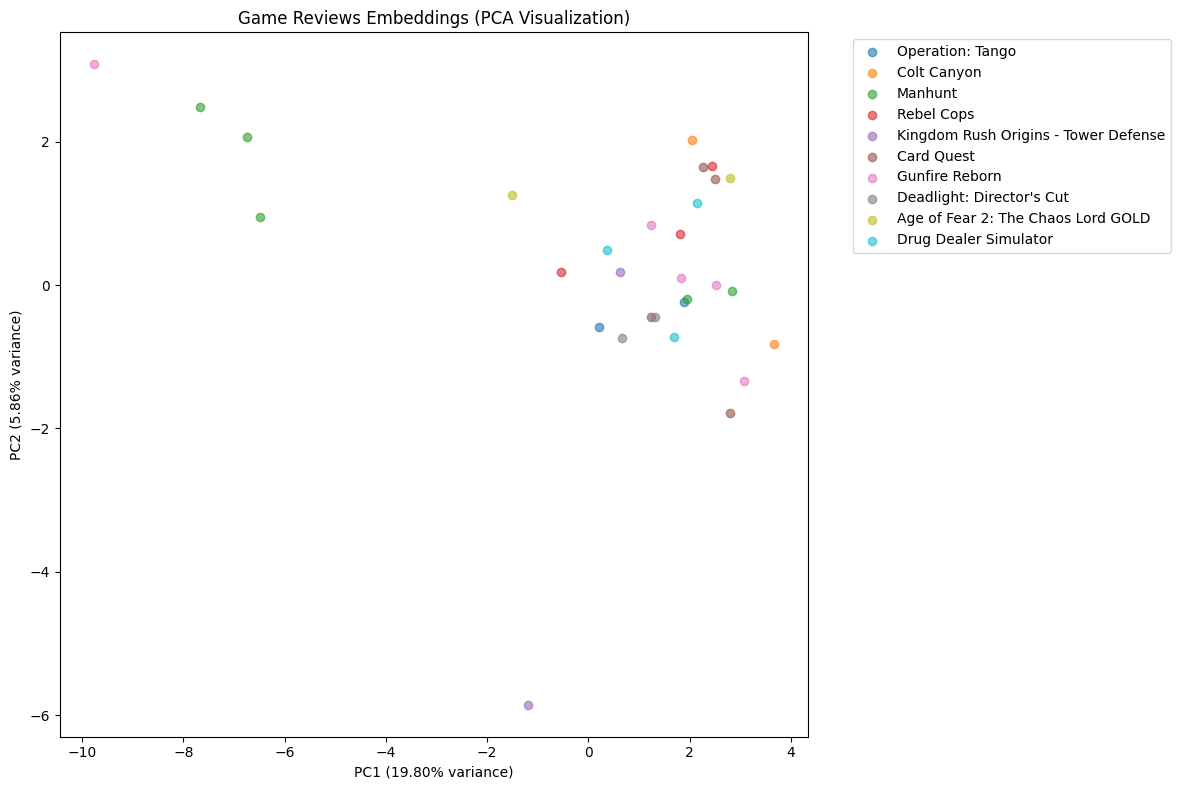

PCA explained variance ratio: [0.19797036 0.05864025]


In [12]:
# Optional: Visualize embeddings using PCA
try:
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    
    # Get sentence embeddings for visualization
    sentence_embeddings = [result['sentence_embedding'] for result in all_results]
    games = [result['game'] for result in all_results]
    
    # Apply PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(sentence_embeddings)
    
    # Plot
    plt.figure(figsize=(12, 8))
    unique_games = list(set(games))[:10]  # Show only first 10 games for clarity
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_games)))
    
    for i, game in enumerate(unique_games):
        game_indices = [j for j, g in enumerate(games) if g == game]
        game_embeddings = embeddings_2d[game_indices]
        plt.scatter(game_embeddings[:, 0], game_embeddings[:, 1], 
                   c=[colors[i]], label=game, alpha=0.6)
    
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title('Game Reviews Embeddings (PCA Visualization)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    
except ImportError:
    print("Matplotlib not available. Install with: pip install matplotlib")


In [6]:
import pandas as pd

def clean_merged_file(file_path='sentence_embeddings_with_text.csv'):
    """
    Membersihkan file hasil merge dari kolom duplikat dan merapikan struktur
    """
    
    # Load file hasil merge
    df = pd.read_csv(file_path)
    print(f"Original merged file shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()[:10]}...")  # Show first 10 columns
    
    # Identifikasi kolom duplikat 'game'
    game_cols = [col for col in df.columns if col == 'game']
    print(f"Found {len(game_cols)} 'game' columns")
    
    if len(game_cols) > 1:
        # Hapus kolom 'game' duplikat (keep the first one)
        cols_to_keep = []
        game_col_added = False
        
        for col in df.columns:
            if col == 'game':
                if not game_col_added:
                    cols_to_keep.append(col)
                    game_col_added = True
                # Skip duplicate 'game' columns
            else:
                cols_to_keep.append(col)
        
        df = df[cols_to_keep]
        print(f"After removing duplicate columns: {df.shape}")
    
    # Reorder columns untuk struktur yang lebih rapi
    embedding_cols = [col for col in df.columns if col.startswith('embedding_')]
    
    # Urutan kolom yang diinginkan
    desired_order = ['row_index', 'game', 'review', 'num_words'] + embedding_cols
    
    # Ambil kolom yang benar-benar ada
    final_cols = [col for col in desired_order if col in df.columns]
    df = df[final_cols]
    
    # Cek dan bersihkan data
    print(f"\nData quality check:")
    print(f"  Missing reviews: {df['review'].isna().sum()}")
    print(f"  Empty reviews: {(df['review'] == '').sum()}")
    print(f"  Unique games: {df['game'].nunique()}")
    print(f"  Total rows: {len(df)}")
    
    # Save cleaned file
    cleaned_file = 'sentence_embeddings_with_text_cleaned.csv'
    df.to_csv(cleaned_file, index=False)
    print(f"\nCleaned file saved as: {cleaned_file}")
    
    # Show sample
    print(f"\nSample cleaned data:")
    print(df[['row_index', 'game', 'review', 'num_words']].head())
    
    return df

# Jalankan pembersihan
cleaned_df = clean_merged_file()


Original merged file shape: (1987, 773)
Columns: ['row_index', 'game', 'game.1', 'review', 'num_words', 'embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4']...
Found 1 'game' columns

Data quality check:
  Missing reviews: 0
  Empty reviews: 0
  Unique games: 100
  Total rows: 1987

Cleaned file saved as: sentence_embeddings_with_text_cleaned.csv

Sample cleaned data:
   row_index                          game  \
0          0  ACE COMBAT™ 7: SKIES UNKNOWN   
1          0  ACE COMBAT™ 7: SKIES UNKNOWN   
2          0  ACE COMBAT™ 7: SKIES UNKNOWN   
3          0  ACE COMBAT™ 7: SKIES UNKNOWN   
4          0  ACE COMBAT™ 7: SKIES UNKNOWN   

                                              review  num_words  
0  My only major negative is the story. All the c...         19  
1  MEH, big meh. Bland storyline, Japanese melodr...         19  
2  Honestly? Just insane. I used to play Ace Comb...         19  
3  I've never played anything from this series be...         19  
